<a href="https://colab.research.google.com/github/moatazaymane/Quora_Question_Pairs/blob/main/Word2vec_From_Scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://jaketae.github.io/study/word2vec/



In [ ]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [ ]:
import re

def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

tokens = tokenize(text)

In [ ]:
type(tokens), len(tokens)

(list, 84)

In [ ]:
def mapping(tokens):
    word_to_id = {}
    id_to_word = {}
    
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
    
    return word_to_id, id_to_word

In [ ]:
word_to_id, id_to_word = mapping(tokens)

In [ ]:
word_to_id['tasks'], id_to_word[15]

(15, 'tasks')

# Generating training data

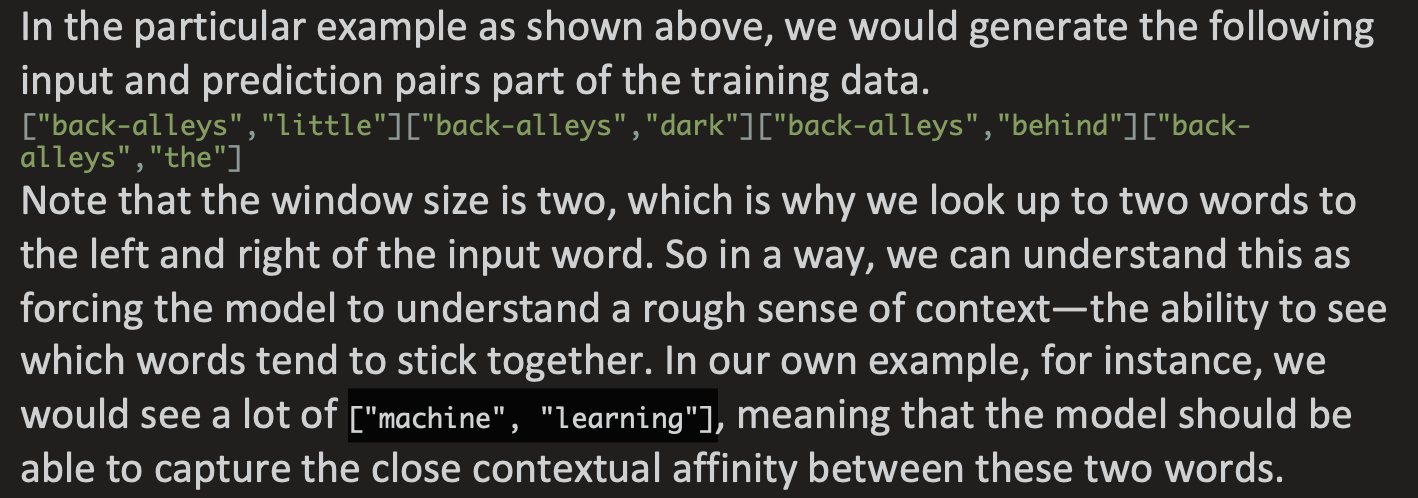

In [ ]:
import numpy as np

np.random.seed(42)


def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [ ]:
def concat(*iterables):
    for iterable in iterables:
        yield from iterable

In [ ]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

In [ ]:
X, y = generate_training_data(tokens, word_to_id, 2)

In [ ]:
X.shape, y.shape

((330, 60), (330, 60))

In [ ]:
np.where(X[205] == 1)[0], np.where(y[205] == 1)[0], np.where(X[206] == 1)[0], np.where(y[206] == 1)[0], np.where(X[207] == 1)[0], np.where(y[207] == 1)[0], np.where(X[208] == 1)[0], np.where(y[208] == 1)[0]

(array([45]),
 array([11]),
 array([45]),
 array([36]),
 array([45]),
 array([12]),
 array([45]),
 array([56]))

# The Embedding model

### **At this point, you might be wondering how it is that training a neural network that predicts some nearby context word given an input token can be used to embed words into vectors.**

After all, the output of the network is going to be some probability vector that passed through a softmax layer, not an embedding vector.

This is entirely correct, and this is a question that came to my mind as well. However, this is the part that gets the most interesting: 

***the rows of the intermediate weight matrix is the embedding we are looking for! This becomes much more apparent once we consider the dimensions of the weight matrices that compose the model. For simplicity purposes, say we have a total of 5 words in the corpus, and that we want to embed these words as three-dimensional vectors.***

A crucial observation to make is that, because the input is a sparse vector containing one-hot encoded vectors, the weight matrix effectively acts as a lookup table that moves one-hot encoded vectors to dense vectors in a different dimension—more precisely, the row space of the weight matrix. In this particular example, the weight matrix was a transformation of ℝ5→ℝ3
. This is exactly what we want to achieve with embedding: representing words as dense vectors, a step-up from simple one-hot encoding. This process is exactly what embedding is: as we start training this model with the training data generated above, we would expect the row space of this weight matrix to encode meaningful semantic information from the training data.

In [ ]:
def init_network(vocab_size, n_embedding):
    model = {
        "w1": np.random.randn(vocab_size, n_embedding),
        "w2": np.random.randn(n_embedding, vocab_size)
    }
    return model

In [ ]:
model = init_network(len(word_to_id), 10)

# Forward propagation

In [ ]:
def forward(model, X, return_cache=True):
    cache = {}
    
    cache["a1"] = X @ model["w1"]
    cache["a2"] = cache["a1"] @ model["w2"]
    cache["z"] = softmax(cache["a2"])
    
    if not return_cache:
        return cache["z"]
    return cache

def softmax(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

In [ ]:
(X @ model["w1"]).shape

(330, 10)

In [ ]:
(X @ model["w1"] @ model["w2"]).shape

(330, 60)

# Backward propagation

In [ ]:
def backward(model, X, y, alpha):
    cache  = forward(model, X)
    da2 = cache["z"] - y
    dw2 = cache["a1"].T @ da2
    da1 = da2 @ model["w2"].T
    dw1 = X.T @ da1
    assert(dw2.shape == model["w2"].shape)
    assert(dw1.shape == model["w1"].shape)
    model["w1"] -= alpha * dw1
    model["w2"] -= alpha * dw2
    return cross_entropy(cache["z"], y)

In [ ]:
def cross_entropy(z, y):
    return - np.sum(np.log(z) * y)

# Testing the model

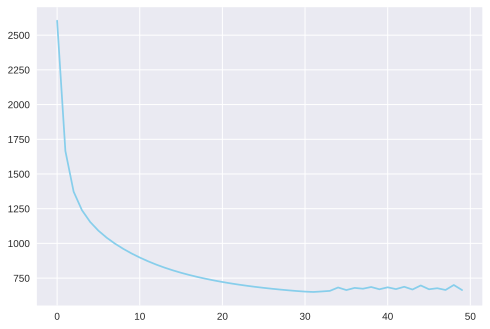

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use("seaborn")

n_iter = 50
learning_rate = 0.05

history = [backward(model, X, y, learning_rate) for _ in range(n_iter)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [ ]:
result

array([1.24458466e-04, 3.09387056e-05, 2.26453318e-07, 1.28967948e-03,
       5.38861940e-07, 2.20856654e-03, 5.89978674e-06, 7.49853402e-05,
       1.95578899e-04, 4.34432827e-02, 5.44049286e-04, 6.87701991e-02,
       1.34818214e-01, 4.50105963e-03, 1.87567137e-06, 1.09783758e-04,
       4.65241584e-04, 2.57656960e-06, 1.52971333e-06, 3.11787108e-06,
       1.05300998e-04, 4.00483355e-06, 4.62006808e-04, 4.44259677e-04,
       1.94640275e-06, 2.77982140e-04, 2.99925502e-05, 3.69537782e-05,
       4.26179315e-06, 1.09771661e-04, 1.42673947e-03, 4.27082420e-05,
       2.11397664e-03, 6.73018475e-02, 1.03174867e-02, 6.49710654e-04,
       4.04103277e-01, 9.10816114e-05, 1.64168105e-03, 2.13328387e-04,
       1.27113295e-04, 7.96958029e-04, 4.07084151e-05, 3.55306147e-03,
       1.54136157e-04, 1.35771071e-02, 8.54544942e-04, 2.35065498e-07,
       6.33047568e-02, 1.14531234e-05, 1.03364319e-05, 1.44396853e-04,
       1.27841988e-06, 4.56309118e-03, 1.08756747e-04, 3.07575685e-05,
      

In [ ]:
np.argsort(result)[::-1]

array([ 2, 47,  4, 52, 18, 14, 24, 17, 19, 21, 28,  6, 50, 49, 26, 55,  1,
       27, 42, 31,  7, 59, 37, 20, 54, 29, 15,  0, 40, 51, 44,  8, 39, 25,
       23, 22, 16, 10, 35, 41, 46,  3, 30, 38, 32,  5, 43, 13, 53, 57, 34,
       45,  9, 56, 48, 33, 11, 58, 12, 36])

In [ ]:
learning = one_hot_encode(word_to_id["learning"], len(word_to_id))
result = forward(model, [learning], return_cache=False)[0]

for word in (id_to_word[id] for id in np.argsort(result)[::-1]):
    print(word)

machine
algorithms
the
so
build
is
are
intelligence
learning
seen
artificial
a
subset
programmed
used
computer
in
improve
of
applications
wide
perform
study
model
infeasible
experience
filtering
vision
based
variety
where
do
data
tasks
conventional
such
to
it
mathematical
needed
known
email
difficult
that
through
automatically
make
as
or
order
and
on
decisions
training
develop
explicitly
sample
without
predictions
being


# Embedding

In [ ]:
# model["w1"]

In [ ]:
def get_embedding(model, word):
    try:
        idx = word_to_id[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word_to_id))
    return forward(model, one_hot)["a1"]

In [ ]:
get_embedding(model, "machine")

array([-0.57619509,  0.94313893, -0.55859074, -0.20299698,  1.18534704,
       -0.33284983, -0.01943192, -1.74890534, -1.3173026 , -0.63360999])

# Conclusion

While this is a relatively simple, basic implementation of word2vec, the underlying principle remains the same nonetheless. The idea is that, we can train a neural network to generate word embeddings in the form of a weight matrix. This is why embedding layers can be trained to generate custom embeddings in popular neural network libraries like TensorFlow or PyTorch. If you end up training word embeddings on large datasets like Wikipedia, you end up with things like word2vec and GloVe, another extremely popular alternative to word2vec. In general, it’s fascinating to think that, with enough data, we can encode enough semantics into these embedding vectors to see relationships such as “king - man + woman = queen.”